In [1]:
%%capture
!pip install torch tqdm matplotlib scikit-learn

In [9]:
import os
import torch
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Plotting Code

### Clustering using t-SNE

In [3]:
def save_activation_projection_tsne(
    split1_activations1,
    split1_activations2,
    split2_activations1,
    split2_activations2,
    fname,
    title,
    split1_label1="Split 1 Positive Examples",
    split1_label2="Split 1 Negative Examples",
    split2_label1="Split 2 Positive Examples",
    split2_label2="Split 2 Negative Examples",
):
    """
    split1_activations1: n_samples x vector dim tensor
    split1_activations2: n_samples x vector dim tensor
    split2_activations1: n_samples x vector dim tensor
    split2_activations2: n_samples x vector dim tensor

    projects to n_samples x 2 dim tensor using t-SNE (over the full dataset of both activations 1 and 2) and saves visualization.
    Colors projected activations1 as blue and projected activations2 as red for the first split.
    Colors projected activations1 as green and projected activations2 as orange for the second split.
    """
    plt.clf()
    activations = torch.cat([split1_activations1, split1_activations2, split2_activations1, split2_activations2], dim=0)
    activations_np = activations.cpu().numpy()

    # t-SNE transformation
    tsne = TSNE(n_components=2)
    projected_activations = tsne.fit_transform(activations_np)

    # Getting back activations1 and activations2 for both splits
    indices = [
        (0, split1_activations1.shape[0]),
        (split1_activations1.shape[0], split1_activations1.shape[0] + split1_activations2.shape[0]),
        (split1_activations1.shape[0] + split1_activations2.shape[0], split1_activations1.shape[0] + split1_activations2.shape[0] + split2_activations1.shape[0]),
        (split1_activations1.shape[0] + split1_activations2.shape[0] + split2_activations1.shape[0], None)
    ]
    split1_activations1_projected = projected_activations[indices[0][0]: indices[0][1]]
    split1_activations2_projected = projected_activations[indices[1][0]: indices[1][1]]
    split2_activations1_projected = projected_activations[indices[2][0]: indices[2][1]]
    split2_activations2_projected = projected_activations[indices[3][0]: indices[3][1]]

    # Visualization for split 1
    for x, y in split1_activations1_projected:
        plt.scatter(x, y, color="blue", marker="o", alpha=0.4)

    for x, y in split1_activations2_projected:
        plt.scatter(x, y, color="red", marker="o", alpha=0.4)
        
    # Visualization for split 2
    for x, y in split2_activations1_projected:
        plt.scatter(x, y, color="green", marker="s", alpha=0.4)

    for x, y in split2_activations2_projected:
        plt.scatter(x, y, color="orange", marker="s", alpha=0.4)

    # Adding the legend
    split1_scatter1 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="blue",
        markersize=10,
        label=split1_label1,
    )
    split1_scatter2 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=10,
        label=split1_label2,
    )
    
    split2_scatter1 = plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="green",
        markersize=10,
        label=split2_label1,
    )
    split2_scatter2 = plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="orange",
        markersize=10,
        label=split2_label2,
    )

    plt.legend(handles=[split1_scatter1, split1_scatter2, split2_scatter1, split2_scatter2])
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.savefig(fname)

In [27]:
def plot_all_activations(dirpath1, dirpath2, layers):
    if not os.path.exists("../save"):
        os.mkdir("../save")
        
    for layer in layers:
        first_pos = torch.load(f"{dirpath1}/positive_layer_{layer}.pt")
        first_neg = torch.load(f"{dirpath1}/negative_layer_{layer}.pt")
        second_pos = torch.load(f"{dirpath2}/positive_layer_{layer}.pt")
        second_neg = torch.load(f"{dirpath2}/negative_layer_{layer}.pt")
        
        # reduce dimensionality using PCA
        pca_dim = min(first_pos.shape[0] + first_neg.shape[0],
                      second_pos.shape[0] + second_neg.shape[0])
        
        first_pca = PCA(n_components=pca_dim)
        first_pca.fit(torch.cat([first_pos, first_neg], dim=0))
        first_pos = torch.tensor(first_pca.transform(first_pos))
        first_neg = torch.tensor(first_pca.transform(first_neg))
        
        second_pca = PCA(n_components=pca_dim)
        second_pca.fit(torch.cat([second_pos, second_neg], dim=0))
        second_pos = torch.tensor(second_pca.transform(second_pos))
        second_neg = torch.tensor(second_pca.transform(second_neg))
        
        save_activation_projection_tsne(
            first_pos,
            first_neg,
            second_pos,
            second_neg,
            f"../save/activations_layer_{layer}.png",
            f"t-SNE projected activations layer {layer}",
            split1_label1="Split 1 Positive Examples",
            split1_label2="Split 1 Negative Examples",
            split2_label1="Split 2 Positive Examples",
            split2_label2="Split 2 Negative Examples"
        )

### Cosine Similarity

In [39]:
import torch.nn.functional as F

def plot_all_cosine_similarity(dirpath1, dirpath2, layers):
    # Stacking all steering vectors
    split1_vec_list, split2_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split1_vec_list.append(split1_vec)    
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        split2_vec_list.append(split2_vec)
        
    # reduce dimensionality
    dim = min(len(split1_vec_list), len(split2_vec_list))
    split1_pca = PCA(n_components=dim)
    split1_vec_list = [torch.tensor(t) for t in split1_pca.fit_transform(split1_vec_list)]
    split2_pca = PCA(n_components=dim)
    split2_vec_list = [torch.tensor(t) for t in split2_pca.fit_transform(split2_vec_list)]
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization 
    plt.plot(layers, cosine_sim, marker='o')
    
    plt.title(f"Cosine Similarity of Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    plt.xlabel("Layer Number")
    plt.ylabel("Cosine Similarity")
    plt.tight_layout()
    plt.savefig("../save/cosine_similarity_vs_layer.png")

In [29]:
first_dirpath = "../save/llama_7b_refusal_data_2splits_0_exp_data"
second_dirpath = "../save/llama_13b_refusal_data_2splits_0_exp_data"
start_layer = 0
end_layer = 31
layer_numbers = list(range(start_layer, end_layer + 1))

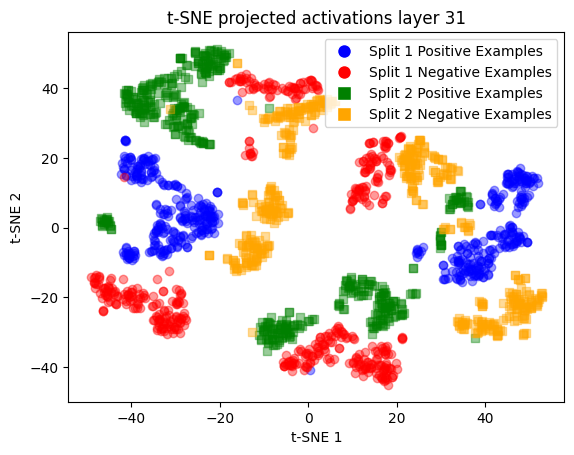

In [30]:
plot_all_activations(first_dirpath, second_dirpath, layer_numbers)

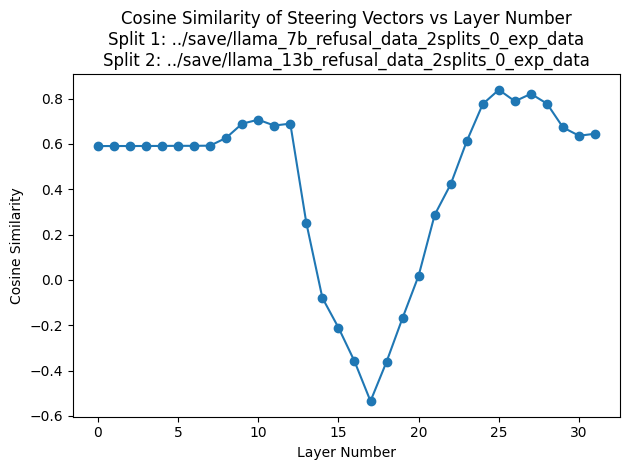

In [40]:
plot_all_cosine_similarity(first_dirpath, second_dirpath, layer_numbers)